# MobileNet

In [52]:
import cv2
import time
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


In [6]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [29]:
FastRCNNPredictor(20, 10)

FastRCNNPredictor(
  (cls_score): Linear(in_features=20, out_features=10, bias=True)
  (bbox_pred): Linear(in_features=20, out_features=40, bias=True)
)

In [3]:
model.classifier[1].weight

Parameter containing:
tensor([[-3.1177e-02,  8.9587e-02, -7.4812e-02,  ..., -3.3275e-02,
         -6.3844e-02, -4.2156e-02],
        [-2.2173e-02,  5.4803e-02,  1.2471e-02,  ..., -4.2400e-02,
         -2.5825e-02,  1.2331e-02],
        [-6.9285e-03,  2.1576e-02, -3.0861e-02,  ..., -7.2696e-02,
         -6.1196e-02, -5.7697e-03],
        ...,
        [-4.4350e-02,  2.8589e-02, -2.1555e-02,  ..., -2.9260e-02,
         -4.3549e-02,  6.3868e-02],
        [-1.9761e-02,  1.3970e-01,  4.8443e-02,  ..., -9.5596e-03,
          1.5066e-03,  1.2227e-04],
        [ 5.1320e-02,  3.0963e-02,  6.9039e-02,  ...,  5.7984e-03,
         -5.5186e-03, -2.5348e-02]], requires_grad=True)

In [33]:
model.roi_heads.box_predictor.bbox_pred.weight.shape


torch.Size([8, 1024])

In [39]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [36]:
print(output.shape)

torch.Size([1, 1000])


In [40]:

#  print(output[0])
print((torch.nn.functional.softmax(output[0], dim=0).shape))
    

torch.Size([1000])


In [17]:
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]

In [18]:
len(CLASSES)

21

## Fine-Tuning MobileNet
Adding Object Detection head to MobileNet

In [58]:
mobile_net = torchvision.models.mobilenet_v2(pretrained=True)

In [35]:
# add a different backbone i.e. MobileNet to FasterRCNN model trained on COCO

backbone = torchvision.models.mobilenet_v2(pretrained=True).features 

# from the layer before the classifier
backbone.out_channels = 1280

# let's define the anchor generators and RoI pooler

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios = ((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
num_classes = len(CLASSES)
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool = roi_pooler)


In [53]:
rows = open('synset_words.txt').read().strip().split("\n")
classes = [r[r.find(" ") + 1:].split(",")[0] for r in rows]


In [62]:
len(classes)

1000

In [70]:
filename = 'tesla.jpg'

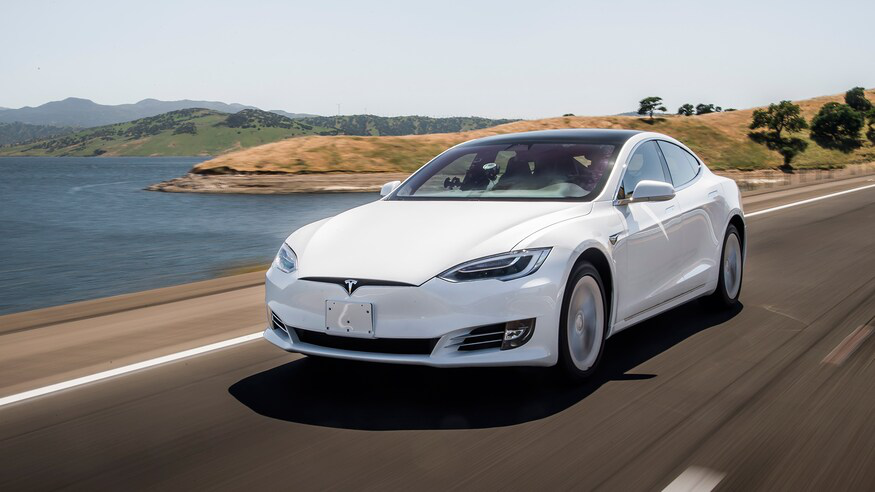

In [71]:
Image.open(filename)

In [80]:
from PIL import Image
from torchvision import transforms

image = Image.open(filename)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    start = time.time()
    mobile_net.eval()
    preds = mobile_net(input_batch)
    end = time.time()
    print("[INFO] classification took {:.5} seconds".format(end - start))


[INFO] classification took 0.47117 seconds


In [171]:
preds[0].shape

torch.Size([1000])

In [134]:
probs = torch.nn.functional.softmax(preds[0], dim=0)

In [140]:
probs[816:820]

tensor([9.9983e-06, 2.7863e-01, 6.4858e-06, 8.1226e-07])

In [138]:
probs.max()

tensor(0.2786)

In [142]:
int(torch.argmax(probs))

817

In [111]:
probs.max()

tensor(0.2786)

In [114]:
sort_probs, indices = torch.sort(probs, descending=True)

In [118]:
sorted_probs = sort_probs[:5]

In [159]:
float(sorted_probs[0] * 100)

27.862686157226562

In [120]:
for i, idx in enumerate(sorted_probs):
    print(idx)

tensor(0.2786)
tensor(0.2057)
tensor(0.1493)
tensor(0.1214)
tensor(0.0850)


In [150]:
image = cv2.imread(filename)

In [166]:
for i, idx in enumerate(sorted_probs):
    if i == 0:
        text = "Label: {}, {:.2f}%".format(classes[int(torch.argmax(probs))],
                                           int(sorted_probs[0] * 100))
        print(classes[int(torch.argmax(probs))])
        cv2.putText(image, text, (100,250), cv2.FONT_HERSHEY_SIMPLEX,
			0.7, (0, 0, 255), 2)
        prob = float(sorted_probs[0] * 100)

        print("[INFO] {}. label: {}, probability: {:.5}".format(i+1, text, prob))

sports car
[INFO] 1. label: Label: sports car, 27.00%, probability: 27.863


In [167]:
cv2.imshow("image", image)
cv2.waitKey(0)

113

In [98]:
sorted_probs = torch.sort(probs, descending=True)

In [99]:
sorted_probs[:5]

(tensor([2.7863e-01, 2.0565e-01, 1.4926e-01, 1.2136e-01, 8.4960e-02, 6.2772e-02,
         3.5881e-02, 7.7858e-03, 7.2705e-03, 7.2089e-03, 3.6038e-03, 3.2895e-03,
         2.6725e-03, 1.4997e-03, 1.4624e-03, 1.3609e-03, 1.1092e-03, 1.1057e-03,
         8.5138e-04, 6.9628e-04, 6.5240e-04, 6.3948e-04, 5.3815e-04, 4.0028e-04,
         3.6359e-04, 3.1938e-04, 3.1175e-04, 2.9910e-04, 2.8577e-04, 2.8502e-04,
         2.8199e-04, 2.7949e-04, 2.7616e-04, 2.6851e-04, 2.6124e-04, 2.2567e-04,
         2.2358e-04, 2.1367e-04, 2.0331e-04, 2.0029e-04, 1.9634e-04, 1.7585e-04,
         1.7379e-04, 1.5066e-04, 1.4315e-04, 1.4159e-04, 1.4005e-04, 1.3551e-04,
         1.3013e-04, 1.2959e-04, 1.2882e-04, 1.2763e-04, 1.2725e-04, 1.2385e-04,
         1.2243e-04, 1.2121e-04, 1.1770e-04, 1.1716e-04, 1.1347e-04, 1.1237e-04,
         1.1095e-04, 1.0951e-04, 1.0944e-04, 1.0778e-04, 1.0417e-04, 1.0037e-04,
         9.7193e-05, 9.5778e-05, 9.4242e-05, 9.0884e-05, 8.8986e-05, 8.8162e-05,
         8.7896e-05, 8.6907e

In [51]:
output.shape

torch.Size([1, 1000])

In [43]:
mobile_net = torchvision.models.mobilenet_v2(pretrained=True)

In [44]:
mobile_net.eval()
output = mobile_net(input_batch)

In [46]:
output.max()

tensor(10.7004, grad_fn=<MaxBackward1>)

In [48]:
output.shape

torch.Size([1, 1000])

In [12]:
model.rpn.head.cls_logits.weight.shape

torch.Size([15, 1280, 1, 1])

In [16]:
model.rpn.head.bbox_pred.weight.shape

torch.Size([60, 1280, 1, 1])

# MobileNet for Detection